# Time dependent split for HELIOS++
Simulating large scenes with HELIOS++ can lead to running out of memory, as to many large objects are loaded in at the same time. This script circumvents this issue by automatically dividing the survey into smaller sub surveys based on a user defined interval size.   
We implement this by creating bounding box .objs out of each scene part, simulating them individually and then assess the objects that are present for each interval.  
Using this information we can then create interval surveys with only the relevant objects.  
The resulting point clouds are then filtered so only points within their timespan remain. 



## Intial steps

First we need to load in the needed modules

In [1]:
import time_dependent_split_functions_22_10 as tds
import os
from pathlib import Path
import numpy as np
import xml.etree.ElementTree as ET
import pyhelios

Now we need to add the path to the survey we want to process and the desired output folder.
The paths to the folders that are used to store intermediate data are created based upon this input. 

In [2]:
os.chdir("C:/Users/an274/heliospp_alt")
assets = [os.getcwd()]
original_survey = "C:/Users/an274/heliospp_alt/data/surveys/demo/tds_trees_survey.xml"
outdir = "C:/Users/an274/heliospp_alt/output"
survey_name = ET.parse(original_survey).find('survey').attrib['name']
original_scene = ET.parse(original_survey).find('survey').attrib['scene'].split('#')[0]
original_scene_fname = Path(original_scene).stem
scene_dir = Path(original_scene).parent
scene_name = ET.parse(original_survey).find('survey').attrib['scene'].split('#')[1]
split_scene_dir = scene_dir / f"{original_scene_fname}_split"
sp_surveys_dir = f"{Path(original_survey).stem}_per_sp"
bboxes_obj_dir = Path(scene_dir) / f'{original_scene_fname}_bboxes'
bboxes_pc_dir = Path(outdir) / survey_name / 'bbox_surveys'
merged_bboxes_pc = Path(scene_dir) / f'{original_scene_fname}_bboxes.laz'
interval_surveys_dir = Path(outdir) / survey_name / 'interval_surveys'
merged_intervals_dir = Path(outdir) / survey_name / 'merged_intervals'  # add timestamp?
merged_filtered_intervals_dir = Path(outdir) / survey_name / 'merged_filtered_intervals'  # add timestamp?
final_pc = Path(outdir) / survey_name / f'{survey_name}_final.laz'  # add timestamp?
Path(bboxes_obj_dir).mkdir(parents=True, exist_ok=True)
Path(split_scene_dir).mkdir(parents=True, exist_ok=True)
Path(merged_intervals_dir).mkdir(parents=True, exist_ok=True)
Path(merged_filtered_intervals_dir).mkdir(parents=True, exist_ok=True)

Here we set some important variables for our script.   
fixed_gps_time sets the time for the sim, thus all sims start at the same time.   
obj_of_int is an optional parameter. If we only want to simulate intervals where one or more objects of interest are scanned, we need to input their IDs in this list.   
interval indicates the length in seconds of the intervals that are used to divide the survey.   
ext = Here we can decide wether we want our final point cloud saved in .laz or .las format.    

In [3]:
fixed_gps_time = "2024-07-07 00:00:00"
obj_of_int = []
interval = 6
ext = "las"

## Create sub surveys and derive bounding boxes

This chunk first splits the original scene into several sub scenes, one for each scene part. For each sub scene file a sub survey file is created and initiated. The min and max coordinates of the scene parts bounding box is stored in a previously created numpy array.

In [4]:
split_scene_files = tds.split_xml(original_scene, split_scene_dir)

mins = np.zeros(shape=(len(split_scene_files), 3))
maxs = np.zeros(shape=(len(split_scene_files), 3))

# Run simulation for each scene part to get bounding box information.
print("\nGetting bounding boxes\n")
for i, paths in enumerate(split_scene_files):
    # Write new survey for each scene part scene based on original survey
    survey = tds.write_survey(original_survey, paths, suffix=f"sub_{i}", 
                              subfolder=sp_surveys_dir)

    pyhelios.loggingSilent()
    # Build simulation parameters
    simBuilder = pyhelios.SimulationBuilder(
        str(survey),
        assets,
        outdir
    )
    simBuilder.setNumThreads(0)
    simBuilder.setRebuildScene(True)
    simBuilder.setLasOutput(True)
    simBuilder.setZipOutput(True)

    simB = simBuilder.build()
    scene = simB.sim.getScene()
    shift = scene.getShift()
    part = scene.getScenePart(0)
    part.computeBound()
    bbox = part.getBound()

    min_coords = [bbox.getMinVertex().getPosition().x + shift.x,
                  bbox.getMinVertex().getPosition().y + shift.y,
                  bbox.getMinVertex().getPosition().z + shift.z]
    max_coords = [bbox.getMaxVertex().getPosition().x + shift.x,
                  bbox.getMaxVertex().getPosition().y + shift.y,
                  bbox.getMaxVertex().getPosition().z + shift.z]

    mins[i] = min_coords
    maxs[i] = max_coords


Getting bounding boxes

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 2.7195112 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 2.6942969999999997 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 2.4956394999999993 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 2.4757797000000004 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 2.6134809000000008 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 2.5200742 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 2.685973100000002 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 2.5050418000000008 seconds


Using the min and max coordinated obtained earlier, we now create .obj files of the bounding boxes. These are then used to create sub scenes and surveys again. 

In [5]:
objs_outfiles = []
for i, (min_val, max_val) in enumerate(zip(mins, maxs)):
    obj_outfile = tds.create_obj_box(
        min_val, max_val, f"bbox_{i+1}.obj", bboxes_obj_dir
    )
    objs_outfiles.append(obj_outfile)

bbox_scene_outfiles = tds.write_bbox_scenes(bboxes_obj_dir, objs_outfiles)
survey_outfiles = tds.write_multiple_surveys(original_survey, 
                                             bbox_scene_outfiles, 
                                             bboxes_obj_dir,
                                             f"bbox_survey")

## Run bounding box surveys and analyse intervals

We now run each of the bounding box sub surveys. note that this time the surveys are actually run, instead of only initiating to access the scenepart attributes. 
Both the individual legs and the surveys are then merged.

In [6]:
print("\nSimulating over bounding boxes\n")
bbox_output_files = []
for path in survey_outfiles:
    pyhelios.loggingSilent()
    # Build simulation parameters

    simBuilder = pyhelios.SimulationBuilder(
        str(path),
        assets,
        str(bboxes_pc_dir)
    )
    simBuilder.setNumThreads(0)
    simBuilder.setRebuildScene(True)
    simBuilder.setLasOutput(True)
    simBuilder.setZipOutput(True)
    simBuilder.setFixedGpsTimeStart(fixed_gps_time)
    simB = simBuilder.build()

    sim = simBuilder.build()
    sim.start()
    output = sim.join()
    for j in range(output.outpaths.length()):
        bbox_output_files.append(output.outpaths.get(j))

tds.laz_merge(bbox_output_files, merged_bboxes_pc)


Simulating over bounding boxes

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.013804199999999156 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.007197200000000237 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.009011799999999681 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.006560000000000343 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.009292399999999645 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.006691199999998787 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.015702499999996178 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.006639200000002177 seconds
SimulationBuilder is building simulation ...
SimulationBuilder built si

WindowsPath('data/scenes/demo/tds_forest_scene_bboxes.laz')

We now analyse this merged bounding box point cloud. For each user defined interval, the scripts checks the unique hitObjectId and informs us which objects are seen in each interval. ### change function for better output  

In [7]:
obj_ids = tds.objs_in_interval(merged_bboxes_pc, interval)

Objects with the following IDs where scanned:[1 2 3 4 5 6 7 8]
Object IDs in Interval 1:[1 2 4 5 8]
Object IDs in Interval 2:[1 2 4 5 6 8]
Object IDs in Interval 3:[1 2 3 6 8]
Object IDs in Interval 4:[1 2 3 4 5 6 7 8]
Object IDs in Interval 5:[1 2 3 4 5 6 7 8]


## Run and filter interval surveys

We then once again create sub scenes and sub surveys for each interval, with bonly the scanned objects in the scene file. 
If two intervals have the same object composition, only one scene is created, saving computation time later.

In [8]:
interval_scene_outfiles = tds.gen_interval_scene(original_scene,
                                                 scene_dir,
                                                 obj_ids,
                                                 obj_of_int)
interval_surveys = tds.write_multiple_surveys(original_survey, 
                                              interval_scene_outfiles,
                                              scene_dir,
                                              f"interval_survey")

Scene with parts [1 2 3 4 5 6 7 8] already created. Skipping...


Now we run the simulation on the interval surveys

In [9]:
interval_output_folders = []
# Run simulation for each interval survey.
print(f"\nSimulating {len(interval_surveys)} separate intervals\n")
for i, path in enumerate(interval_surveys):
    print(f"\nInterval {i+1}")
    pyhelios.loggingSilent()

    # Build simulation parameters
    simBuilder = pyhelios.SimulationBuilder(
        str(path),
        assets,
        str(interval_surveys_dir)
    )
    simBuilder.setNumThreads(0)
    simBuilder.setRebuildScene(True)
    simBuilder.setLasOutput(True)
    simBuilder.setFixedGpsTimeStart(fixed_gps_time)

    sim = simBuilder.build()
    sim.start()
    output = sim.join()
    interval_output_folders.append(Path(output.outpath).parent)
    print("t")


Simulating 4 separate intervals


Interval 1
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 13.122655299999991 seconds

Interval 2
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 15.527631899999989 seconds

Interval 3
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 13.080915299999987 seconds

Interval 4
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 21.75364909999999 seconds


The output of the interval surveys is now filtered. This is done by discarding points with a gpsTime outside of the user defined interval for each interval sub survey output. 
The filtered interval point clouds are then merged to our final point cloud.

In [10]:
merged_interval_paths = []
for i, interval_dir in enumerate(interval_output_folders):
    paths = list(Path(interval_dir).glob(f"*.{ext}"))
    outpath = Path(merged_intervals_dir) / f"merged_interval_{i+1}.laz"
    tds.laz_merge(paths, outpath)
    merged_interval_paths.append(outpath)

# Filter merged interval pcs to points inside the interval time.
print("\nMerging intervals\n")
tds.filter_and_write(merged_interval_paths, 
                     merged_filtered_intervals_dir,
                     obj_ids,
                     obj_of_int,
                     interval)


# Merge filtered interval pcs to final pc.
filtered_clouds_path = []
for file in os.listdir(merged_filtered_intervals_dir):
    filtered_clouds_path.append(
        os.path.join(merged_filtered_intervals_dir, file)
        )
tds.laz_merge(filtered_clouds_path, final_pc)
print("t")

Leg 0 not empty. Merging...
Leg 0 not empty. Merging...
Leg 0 not empty. Merging...
Leg 0 not empty. Merging...

Merging intervals

interval 1 ranging from 0 to 6
Filtered 163717 points from a total of 1126965 points
no field of name fullwaveIndex
no field of name hitObjectId
no field of name heliosAmplitude
Wrote intervall 1
interval 2 ranging from 6 to 12
Filtered 249551 points from a total of 1421680 points
no field of name fullwaveIndex
no field of name hitObjectId
no field of name heliosAmplitude
Wrote intervall 2
interval 3 ranging from 12 to 18
Filtered 335605 points from a total of 1115162 points
no field of name fullwaveIndex
no field of name hitObjectId
no field of name heliosAmplitude
Wrote intervall 3
interval 4 ranging from 18 to 24
Filtered 473583 points from a total of 1500254 points
no field of name fullwaveIndex
no field of name hitObjectId
no field of name heliosAmplitude
Wrote intervall 4
interval 5 ranging from 24 to 30
Filtered 277798 points from a total of 1500254

WindowsPath('C:/Users/an274/heliospp_alt/output/uls_tds_trees/uls_tds_trees_final.laz')

This lets us delete all the intermediate files we created to save storage.

In [11]:
paths_to_delete = [sp_surveys_dir, bboxes_obj_dir, bboxes_pc_dir, interval_surveys_dir, merged_intervals_dir, merged_bboxes_pc, split_scene_dir]
paths_to_delete += objs_outfiles + interval_output_folders
#tds.delete_files(paths_to_delete)

# Comparison with reference point cloud


Now we compare our result with a reference point cloud from the command line.

In [20]:
!helios data/surveys/tds/tds_trees.xml --quiet --lasOutput --output output/reference_cloud

The resulting legs are then merged. Add the correct file name for the reference_path.

In [28]:
reference_path = Path(outdir) / "reference_cloud" / survey_name / "2024-10-30_12-56-16"
reference_pc = Path(outdir) / "uls_tds_trees" / 'rf_pc.laz'
reference_legs_paths = []
for file in os.listdir(reference_path):
    reference_legs_paths.append(
        os.path.join(reference_path, file)
        )
tds.laz_merge(reference_legs_paths, reference_pc)

Leg 0 not empty. Merging...


WindowsPath('C:/Users/an274/heliospp_alt/output/uls_tds_trees/rf_pc.laz')

As we can see, both point clouds have the same number of points.

In [29]:
coords_tds, attr_tds = tds.read_las(final_pc)
coords_ref, attr_ref = tds.read_las(reference_pc)
print(f"Total amount of points in tds final cloud: {len(coords_tds)} ")
print(f"Total amount of points in reference cloud: {len(coords_ref)} ")

Total amount of points in tds final cloud: 1500254 
Total amount of points in reference cloud: 1500254 


We can also construct a kdtree to assess the nearest neighbour distances between reference and tds cloud.

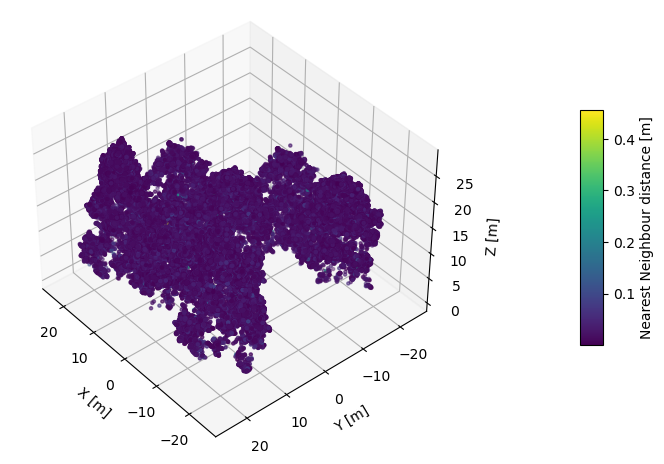

In [30]:
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

reference_tree = KDTree(coords_ref)
nn_dists = reference_tree.query(coords_tds, k=1)

# obtain distances as first element in tuple returned by query above
distances = nn_dists[0]

# create a figure with 3D axis (two columns for different coloring)
fig, ax = plt.subplots(1,1,subplot_kw={"projection": "3d"},figsize=(7,5))

nth=10

# plot the point cloud colored by height (z values)
s = ax.scatter(coords_tds[::nth,0], coords_tds[::nth,1], coords_tds[::nth,2], s=5,
                   c=distances[::nth])

# label axes and add title
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

# set initial view of 3D plot
ax.view_init(elev=40., azim=140.)

# add a colorbar
fig.colorbar(s, shrink=.5, aspect=10, label='Nearest Neighbour distance [m]', ax = ax, pad=0.2)

# show the plot
plt.tight_layout()
plt.show()

We can also plot a histogram showing the NN distance distribution.  
As we can see, most points are situated closely to their nearest neighbour, with only around 600 having a distance greater than 20 centimeters. 

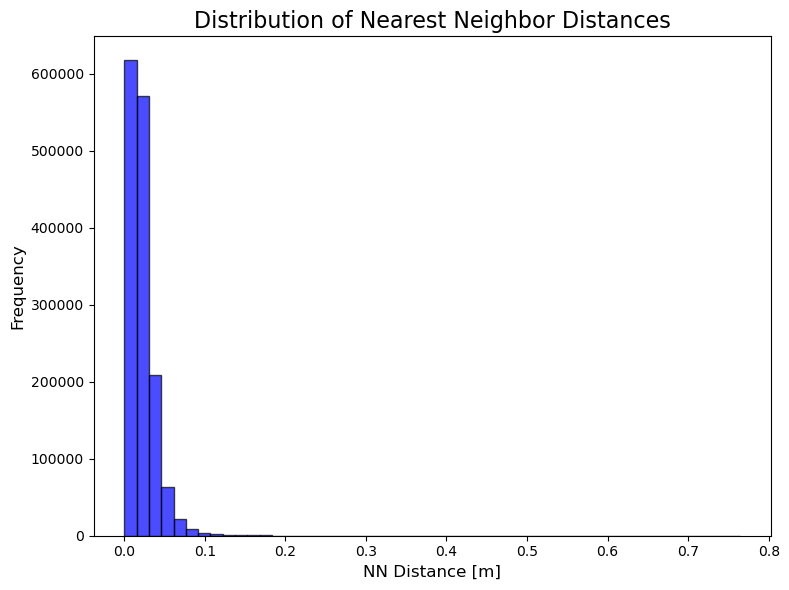

In [31]:
# Plotting the distribution of nearest neighbor distances
plt.figure(figsize=(8,6))

# Create histogram of NN distances
plt.hist(distances, bins=50, color='blue', edgecolor='black', alpha=0.7)

# Add title and labels
plt.title('Distribution of Nearest Neighbor Distances', fontsize=16)
plt.xlabel('NN Distance [m]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [32]:
filtered_distances = distances[distances > 0.2]
len(filtered_distances)

590